In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr
%matplotlib inline

In [2]:
# Create the mesh for laminate microstructure
square = mshr.Rectangle(Point(0, 0), Point(1, 1))
strip = mshr.Rectangle(Point(0.25, -1), Point(0.75, 1))

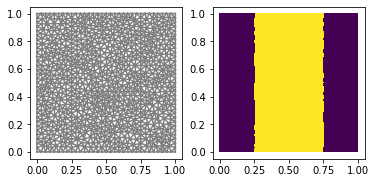

In [3]:
square.set_subdomain(1, strip)
mesh = mshr.generate_mesh(square,24)

subdomain_marker = MeshFunction('size_t', mesh, mesh.topology().dim(),
                               mesh.domains())
plt.subplot(1,2,1)
plot(mesh)
plt.subplot(1,2,2)
plot(subdomain_marker)

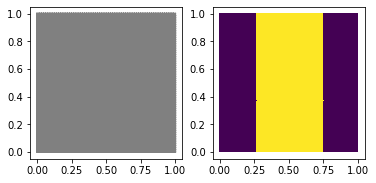

In [4]:
## This second method will produce the better results 
# because the mesh is well structured

mesh = UnitSquareMesh(64, 64, "left")

class Strip(SubDomain):
    def inside(self, x, on_boundary):
        return (x[0] >= 0.25 + DOLFIN_EPS_LARGE) and (x[0] <= 0.75 + DOLFIN_EPS_LARGE)

subdomain_marker = MeshFunction('size_t', mesh, mesh.topology().dim())
strip = Strip()
strip.mark(subdomain_marker, 1)
plt.subplot(1,2,1); plot(mesh)
plt.subplot(1,2,2); plot(subdomain_marker)

In [5]:
# Subdomain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    
    # Constructor
    def __init__(self, verticies):
        super().__init__()
        self.vertices = vertices

    # Left boundary is "tangent domain" G
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        left = near(x[0], self.vertices[0,0], DOLFIN_EPS)
        bottom = near(x[1], self.vertices[0,1], DOLFIN_EPS)
        top_left = near(x[0], self.vertices[0,0], DOLFIN_EPS) \
                        and near(x[1], self.vertices[1,1], DOLFIN_EPS)
        bottom_right = near(x[1], self.vertices[0,1], DOLFIN_EPS) \
                        and near(x[0], self.vertices[1,0], DOLFIN_EPS)
        bottom_left = near(x[0], self.vertices[0, 0], DOLFIN_EPS) \
                and near(x[1], self.vertices[0, 1], DOLFIN_EPS) 
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    # Map right boundary (R) to the left boundary (L)
    def map(self, x, y):
        if near(x[0], self.vertices[1,0], DOLFIN_EPS) \
                and near(x[1], self.vertices[1,1], DOLFIN_EPS):  # top right
            y[0] = x[0] - (self.vertices[1,0] - self.vertices[0,0])
            y[1] = x[1] - (self.vertices[1,1] - self.vertices[0,1])
        elif near(x[0], self.vertices[1,0], DOLFIN_EPS):  # right boundary
            y[0] = x[0] - (self.vertices[1,0] - self.vertices[0,0])
            y[1] = x[1]
        else:    # top boundary
            y[0] = x[0]
            y[1] = x[1] - (self.vertices[1,1] - self.vertices[0,1])
        
# Create an instance of periodic boundary condition
vertices = np.array([[0, 0], [1, 1]])
pbc = PeriodicBoundary(vertices)

In [6]:
class BottomLeft(SubDomain):
    
    # Constructor
    def __init__(self, verticies):
        super().__init__()
        self.vertices = vertices
        
    def inside(self, x, on_boundary):
        return near(x[0], self.vertices[0, 0], DOLFIN_EPS) \
                and near(x[1], self.vertices[0, 1], DOLFIN_EPS) 
# Create an instance of fixed bottom-left boundary condition
fixedBottomLeft = BottomLeft(np.array([[0, 0], [1, 1]]))

A 2D mesh is created using built-in class UnitSquareMesh, and we define a finite element function space relative to this mesh. Notice the fourth argument of FunctionSpace. It specifies that all functions in V have periodic boundaries defined by "pbc". Also notice that in order for periodic boundary conditions to work correctly it is necessary that the mesh nodes on the periodic boundaries match up. This is automatically satisfied for UnitSquareMesh but may require extra care with more general meshes (especially externally generated ones).

In [63]:
class K(UserExpression):
    def __init__(self, materials, k_0, k_1, **kargs):
        super().__init__()
        self.materials = materials
        self.k_0 = k_0
        self.k_1 = k_1
        
    def eval_cell(self, values, x, cell):
        if self.materials[cell.index] == 0:
            values[0] = self.k_0
        else:
            values[0] = self.k_1
    
    def value_shape(self):
        return ()
    
kappa = K(subdomain_marker, 1.0, 5.0, degree=2, element=mesh.ufl_cell())

In [64]:
# Define function space
ElemU = FiniteElement("CG", mesh.ufl_cell(), 2)
ElemL = FiniteElement("R", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([ElemU, ElemL]), 
                  constrained_domain=PeriodicBoundary(vertices))
V = FunctionSpace(mesh, ElemU)

In [65]:
# Define variational problem
u, c = TrialFunction(W)
v, d = TestFunction(W)
w = Function(W)
E = Constant(np.array([0.5, 1]))

In [66]:
dx = Measure('dx', subdomain_data=subdomain_marker)

# a = sum([kappa * dot(grad(u), grad(v))*dx(i) + c*v*dx(i) + u*d*dx(i) for i in range(2)])
a = kappa * dot(grad(u), grad(v))*dx + c*v*dx + u*d*dx
L = kappa * dot(E, grad(v)) * dx

In [67]:
# Solve the variational problem for solution
w = Function(W)
u_sol = Function(V)
lagrange_mul = Function(FunctionSpace(mesh, ElemL))
solve(a == L, w, [])

(u_sol, lagrange_mul) = w.split()

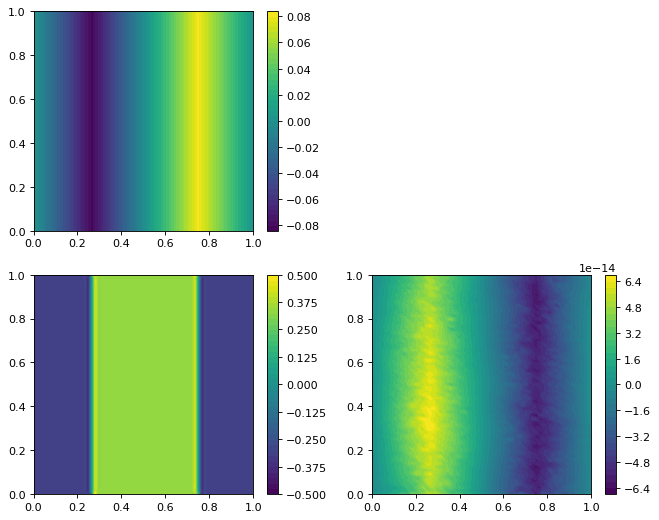

In [68]:
plt.figure(figsize=(10, 8), dpi=80)
plt.subplot(2, 2, 1)
p = plot(u_sol); plt.colorbar(p)
plt.subplot(2, 2, 3)
p = plot(grad(u_sol)[0]); plt.colorbar(p)
plt.subplot(2, 2, 4)
p = plot(grad(u_sol)[1]); plt.colorbar(p)

In [69]:
print('average of u = ', assemble(u_sol*dx))
print('average of Lagrange multipliyer = ', assemble(lagrange_mul*dx))

average of u =  -1.1489440770177028e-16
average of Lagrange multipliyer =  -1.3749230177844065e-12


In [70]:
assemble(((E + grad(u_sol))[0])*dx), assemble(((E + grad(u_sol))[1])*dx)

(0.5000000000000142, 0.9999999999999997)